In [2]:
#Moutning google drive 
from google.colab import drive

drive.mount('/content/drive')

#To run in your drive, go to https://drive.google.com/drive/folders/1LRva9e7OzdmhzFJwYVBWt14lF6PnLHnD?usp=sharing and copy the entire folder in your own drive then run this block and sign in with the auth token for your account.

Mounted at /content/drive


In [3]:
#Loading dataset and changing working directory to drive 
import pandas as pd
import numpy as np
import os
path = '/content/drive/MyDrive/ML Project/dataset_imdb.csv'
path2 = '/content/drive/MyDrive/ML Project/Positive and Negative Word List.xlsx'
os.chdir('/content/drive/MyDrive/ML Project')
dataset = pd.read_csv(path)
PN_words = pd.read_excel(path2)

In [4]:
#Importing all the required libraries 
import re
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import joblib
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score, r2_score

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26963 entries, 0 to 26962
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                26963 non-null  int64  
 1   rating-other-user-rating  25268 non-null  float64
 2   point-scale               25268 non-null  object 
 3   title                     26963 non-null  object 
 4   title href                26963 non-null  object 
 5   display-name-link         26963 non-null  object 
 6   display-name-link href    26963 non-null  object 
 7   review-date               26963 non-null  object 
 8   spoiler-warning           1585 non-null   object 
 9   actions                   26963 non-null  object 
 10  text                      26962 non-null  object 
 11  actions 2                 949 non-null    object 
 12  actions 3                 949 non-null    object 
 13  actions href              949 non-null    object 
dtypes: flo

In [7]:
#Selecting the required columns 
dataset_ratings = dataset[['rating-other-user-rating', 'text']].copy()
dataset_ratings.head()

,rating-other-user-rating,text
0,8.0,"The first 80-90% of ""Interstellar"" I absolutel..."
1,6.0,"As someone who likes the cast, loved the conce..."
2,4.0,"Another outer space film from Hollywood, this ..."
3,7.0,"In the near future, Earth is devastated by bli..."
4,7.0,I'm treading on some little used ground. From ...


In [8]:
dataset_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26963 entries, 0 to 26962
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   rating-other-user-rating  25268 non-null  float64
 1   text                      26962 non-null  object 
dtypes: float64(1), object(1)
memory usage: 421.4+ KB


In [9]:
dataset_ratings = dataset_ratings.dropna()
dataset_ratings2 = dataset_ratings.copy()
dataset_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25267 entries, 0 to 26962
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   rating-other-user-rating  25267 non-null  float64
 1   text                      25267 non-null  object 
dtypes: float64(1), object(1)
memory usage: 592.2+ KB


In [10]:
dataset_ratings['rating-other-user-rating'].value_counts()

10.0    4521
1.0     4297
8.0     3485
9.0     3326
7.0     2817
6.0     2031
5.0     1586
4.0     1089
3.0     1058
2.0     1057
Name: rating-other-user-rating, dtype: int64

#**Text Preprocessing for dataset (with lematization)** 


In [11]:
path3 = '/content/drive/MyDrive/ML Project/dataset_ratings.csv'
dataset_ratings = pd.read_csv(path3)
#Directly run the last cell under this section if you dont want to re-preprocess the data. This preprocessed data was converted to csv as rerunning the code took too much time due to limited computational power
#Strictly don't import the data and re-preprocess it at the same time, it will lead to increase in features meaning you will have to retrain the models 

In [12]:
#Lemmatization run this cell to define the function 
spacy_tockenizer = spacy.load('en', disable=['parser', 'ner'])

# function to lemmatize text
def lemmatization(texts):
    output = []
    for i in texts:
        s = [token.lemma_ for token in spacy_tockenizer(i)]
        output.append(' '.join(s))
    return output

In [ ]:
#Removing URLs
dataset_ratings['cleaned-reviews'] = dataset_ratings['text'].apply(lambda x: re.sub(r'http\S+', '', x)) 

In [ ]:
#Lowercasing Text
dataset_ratings['cleaned-reviews'] = dataset_ratings['cleaned-reviews'].str.lower()

In [ ]:
#Removing numbers 
dataset_ratings['cleaned-reviews'] = dataset_ratings['cleaned-reviews'].apply(lambda x: re.sub(r'\d+', '', x))

In [ ]:
#Removing whitespace 
dataset_ratings['cleaned-reviews'] = dataset_ratings['cleaned-reviews'].apply(lambda x:' '.join(x.split()))

In [ ]:
#dataset_ratings['cleaned-reviews'] = lemmatization(dataset_ratings['cleaned-reviews'])

In [ ]:
#Removing Puncutations except ? and !
punctuation = '"#$%&()*+-/:;<=>@[\\]^_`{|}~'

dataset_ratings['cleaned-reviews'] = dataset_ratings['cleaned-reviews'].apply(lambda x: ''.join(ch for ch in x if ch not in set(punctuation)))

In [ ]:
#Total number of words in a review 
dataset_ratings['total number of words'] = dataset_ratings['cleaned-reviews'].apply(lambda x: len(x.split()))
dataset_ratings.head()

,Unnamed: 0,rating-other-user-rating,text,cleaned-reviews,total number of words,total number of postive words,total number of negative words
0,0,8.0,"The first 80-90% of ""Interstellar"" I absolutel...",the first of interstellar i absolutely loved ...,169,63,22
1,1,6.0,"As someone who likes the cast, loved the conce...","as someone who likes the cast, loved the conce...",375,115,31
2,2,4.0,"Another outer space film from Hollywood, this ...","another outer space film from hollywood, this ...",217,67,28
3,3,7.0,"In the near future, Earth is devastated by bli...","in the near future, earth is devastated by bli...",315,104,38
4,4,7.0,I'm treading on some little used ground. From ...,i'm treading on some little used ground. from ...,224,62,32


In [ ]:
#Function to list positive words 
def pwords(text):
  pno = 0
  PW = PN_words['Positive Sense Word List'].tolist()
  x = text.split()
  for i in x:
    if (i in PW):
      pno = pno + 1
  return pno

#Function to list negative words
def nwords(text):
  nno = 0
  NW = PN_words['Negative Sense Word List'].tolist()
  x = text.split()
  for i in x:
    if (i in NW):
      nno = nno + 1
  return nno

In [ ]:
#Total number of positive and negative words in a review 
dataset_ratings['total number of postive words'] = dataset_ratings['cleaned-reviews'].apply(lambda x: pwords(x))
dataset_ratings['total number of negative words'] = dataset_ratings['cleaned-reviews'].apply(lambda x: nwords(x))

In [13]:
#dataset_ratings.to_csv('dataset_ratings.csv')
dataset_ratings3 = dataset_ratings.copy()
dataset_ratings.head()

,Unnamed: 0,rating-other-user-rating,text,cleaned-reviews,total number of words,total number of postive words,total number of negative words
0,0,8.0,"The first 80-90% of ""Interstellar"" I absolutel...",the first of interstellar i absolutely love...,191,63,22
1,1,6.0,"As someone who likes the cast, loved the conce...","as someone who like the cast , love the concep...",443,115,31
2,2,4.0,"Another outer space film from Hollywood, this ...","another outer space film from hollywood , this...",236,67,28
3,3,7.0,"In the near future, Earth is devastated by bli...","in the near future , earth be devastate by bli...",355,104,38
4,4,7.0,I'm treading on some little used ground. From ...,PRON be tread on some little use ground . from...,256,62,32


#**Model comparison for lematized text**

In [ ]:
#Initiating the vectorizer 
tfidf = TfidfVectorizer(ngram_range = (1,4), analyzer = 'word', stop_words='english', max_features = 6000000)

In [ ]:
x = tfidf.fit_transform(dataset_ratings['cleaned-reviews'])
y = dataset_ratings['rating-other-user-rating']

In [ ]:
x.shape, y.shape

((25267, 4585928), (25267,))

In [ ]:
#Train test split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 0)

In [ ]:
#uncomment if you want to re-train the model, the trained model can be directly loaded from the below code
#clf = LinearSVC(C = 10, class_weight= 'balanced', dual=True, verbose = 2)
#clf.fit(x_train, y_train)

In [ ]:

#joblib.dump(clf, 'linearsvcmodel.h5')

In [ ]:

loaded_clf = joblib.load('linearsvcmodel.h5')

In [ ]:
y_pred = loaded_clf.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.54      0.91      0.68       859
         2.0       0.67      0.11      0.18       226
         3.0       0.59      0.10      0.17       227
         4.0       0.69      0.13      0.23       230
         5.0       0.44      0.17      0.25       327
         6.0       0.31      0.25      0.28       360
         7.0       0.36      0.33      0.34       587
         8.0       0.37      0.33      0.35       713
         9.0       0.40      0.25      0.31       627
        10.0       0.44      0.73      0.55       898

    accuracy                           0.45      5054
   macro avg       0.48      0.33      0.33      5054
weighted avg       0.45      0.45      0.40      5054



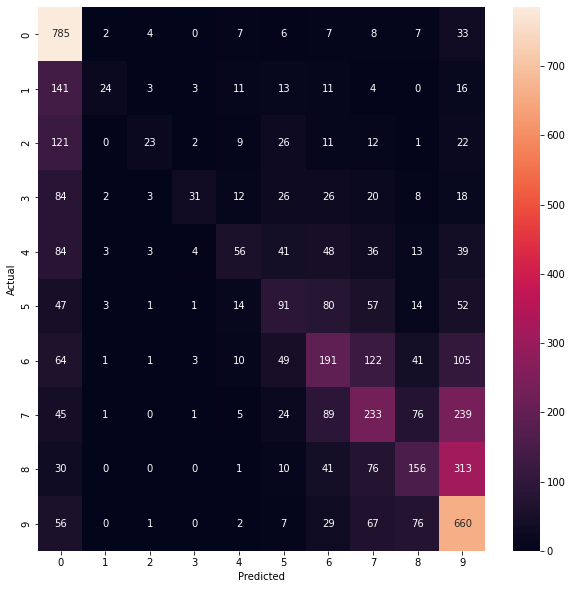

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')  
plt.xlabel('Predicted')
plt.show()

In [ ]:
#uncomment if you want to re-train the model, the trained model can be directly loaded from the below code
#clf2 = LogisticRegression(solver = 'saga', C = 20, class_weight= 'balanced', max_iter= 2000)
#clf2.fit(x_train, y_train)

In [ ]:
#joblib.dump(clf2, 'logisticregressionmodel.h5')


In [ ]:
loaded_clf2 = joblib.load('logisticregressionmodel.h5')

In [ ]:
y_pred2 = loaded_clf2.predict(x_test)
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

         1.0       0.56      0.90      0.69       859
         2.0       0.74      0.10      0.18       226
         3.0       0.59      0.10      0.17       227
         4.0       0.73      0.14      0.24       230
         5.0       0.42      0.17      0.24       327
         6.0       0.30      0.29      0.30       360
         7.0       0.36      0.35      0.35       587
         8.0       0.36      0.36      0.36       713
         9.0       0.40      0.26      0.32       627
        10.0       0.46      0.71      0.55       898

    accuracy                           0.45      5054
   macro avg       0.49      0.34      0.34      5054
weighted avg       0.46      0.45      0.41      5054



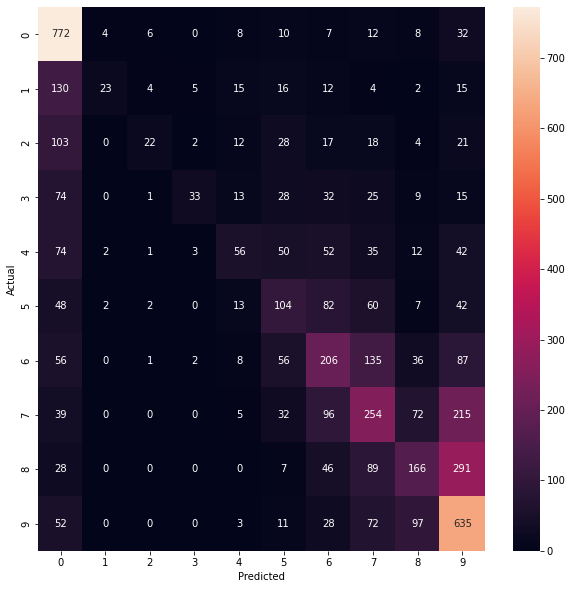

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred2)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
clf3 = (MultinomialNB(alpha=0.01))
clf3.fit((x_train),(y_train))

MultinomialNB(alpha=0.01)

In [ ]:
y_pred3 = clf3.predict(x_test)
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

         1.0       0.66      0.77      0.71       859
         2.0       0.25      0.22      0.23       226
         3.0       0.21      0.22      0.22       227
         4.0       0.17      0.27      0.21       230
         5.0       0.17      0.31      0.22       327
         6.0       0.23      0.37      0.28       360
         7.0       0.36      0.25      0.30       587
         8.0       0.42      0.20      0.27       713
         9.0       0.38      0.36      0.37       627
        10.0       0.51      0.43      0.47       898

    accuracy                           0.39      5054
   macro avg       0.34      0.34      0.33      5054
weighted avg       0.41      0.39      0.39      5054



In [ ]:

#uncomment if you want to re-train the model, the trained model can be directly loaded from the below code
#clf5 = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
#clf5.fit(x_train, y_train)

In [ ]:
#joblib.dump(clf5, 'randomforest.h5')

In [ ]:
loaded_clf5 = joblib.load('randomforest.h5')

In [ ]:
y_pred5 = loaded_clf5.predict(x_test)
print(classification_report(y_test, y_pred5))

              precision    recall  f1-score   support

         1.0       0.39      0.81      0.53       859
         2.0       0.40      0.10      0.16       226
         3.0       0.40      0.09      0.15       227
         4.0       0.48      0.13      0.21       230
         5.0       0.39      0.13      0.20       327
         6.0       0.29      0.14      0.19       360
         7.0       0.35      0.23      0.28       587
         8.0       0.31      0.25      0.27       713
         9.0       0.32      0.25      0.28       627
        10.0       0.32      0.49      0.39       898

    accuracy                           0.35      5054
   macro avg       0.37      0.26      0.27      5054
weighted avg       0.35      0.35      0.31      5054



In [ ]:
#Predicting on sample text 
#Orignal rating 5
xtext ="I'm not going to give a long winded review though the movie was long. 'Eternal' was the runtime. There were parts that were good and parts that weren't. One of the biggest issues is that a movie of this nature presents more questions than it answers. The very existence of eternal beings existing on planet Earth, sent there by their creator in order to protect human life from Deviants, begs a lot of questions. And the more they strayed from their prime directive, the more questions they presented. The eternals were human in every aspect with the exception of their powers and their lifespan. The fact that such humanlike and very fallible beings (as in not entirely obedient) were sent to protect humans is just a start of the questions."
def pptext(text):
  text = re.sub(r'http\S+', '', text)
  text = text.lower()
  text = re.sub(r'\d+', '', text)
  punctuation = '"#$%&()*+-/:;<=>@[\\]^_`{|}~\''
  text = ''.join(ch for ch in text if ch not in set(punctuation))
  text = lemmatization(text)
  text = "".join(text) 
  return text

xp = pptext(xtext)
print(xp)
star_rating = tfidf.transform([xp])
print(loaded_clf.predict(star_rating)[0])
print(loaded_clf2.predict(star_rating)[0])
print(clf3.predict(star_rating)[0])
print(loaded_clf5.predict(star_rating)[0])


im not going to give a long winded review though the movie was long. eternal was the runtime. there were parts that were good and parts that werent. one of the biggest issues is that a movie of this nature presents more questions than it answers. the very existence of eternal beings existing on planet earth, sent there by their creator in order to protect human life from deviants, begs a lot of questions. and the more they strayed from their prime directive, the more questions they presented. the eternals were human in every aspect with the exception of their powers and their lifespan. the fact that such humanlike and very fallible beings as in not entirely obedient were sent to protect humans is just a start of the questions.
5.0
5.0
5.0
8.0


In [ ]:
accuracies = []
f1_scores = []
recalls = []
precisions = []
r2_scores = []


model_names = ['Linear SVC', 'Logistic Regression' , 'Navie Bayes', 'Random forest Classifier']
y_preds = [y_pred, y_pred2, y_pred3, y_pred5 ]

for idx, (names, pred) in enumerate(zip(model_names, y_preds)):
  accuracies.append(accuracy_score(y_test, pred))
  f1_scores.append(f1_score(y_test, pred, average='weighted'))
  recalls.append(recall_score(y_test, pred, average='weighted'))
  precisions.append(precision_score(y_test, pred, average='weighted'))
  r2_scores.append(r2_score(y_test, pred))

In [ ]:
comparing_df = pd.DataFrame.from_dict({
    'name': model_names,
    'accuracy': accuracies,
    'f1 score': f1_scores,
    'recall': recalls,
    'precision': precisions,
    'r squared': r2_scores
})

comparing_df

,name,accuracy,f1 score,recall,precision,r squared
0,Linear SVC,0.445192,0.401549,0.445192,0.450969,0.393268
1,Logistic Regression,0.449347,0.410352,0.449347,0.460556,0.411470
2,Navie Bayes,0.386822,0.385951,0.386822,0.406600,0.328798
3,Random forest Classifier,0.351207,0.314141,0.351207,0.351194,-0.301823


[]

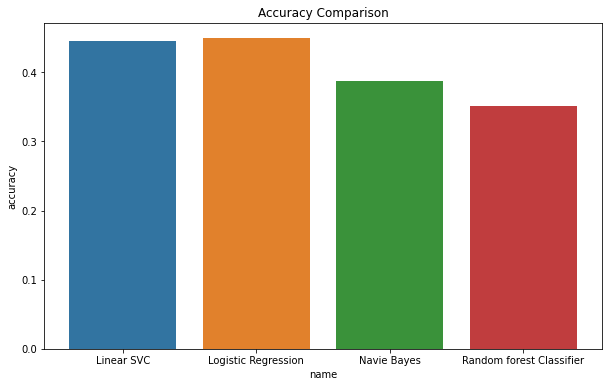

In [ ]:
plt.figure(figsize=(10, 6))

sns.barplot(
    x='name',
    y='accuracy',
    data=comparing_df,
    #order=comparing_df.sort_values('accuracy').name
).set_title('Accuracy Comparison')
plt.plot()

[]

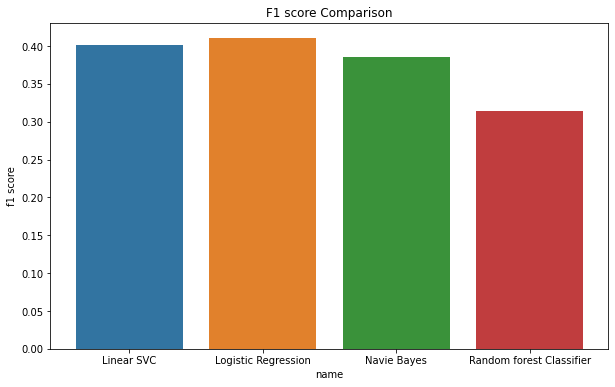

In [ ]:
plt.figure(figsize=(10, 6))

sns.barplot(
    x='name',
    y='f1 score',
    data=comparing_df,
    #order=comparing_df.sort_values('f1_score').name
).set_title('F1 score Comparison')
plt.plot()

[]

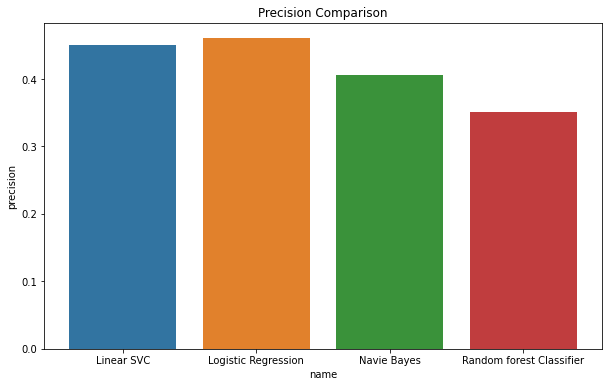

In [ ]:
plt.figure(figsize=(10, 6))

sns.barplot(
    x='name',
    y='precision',
    data=comparing_df,
    #order=comparing_df.sort_values('precision').name
).set_title("Precision Comparison")

plt.plot()

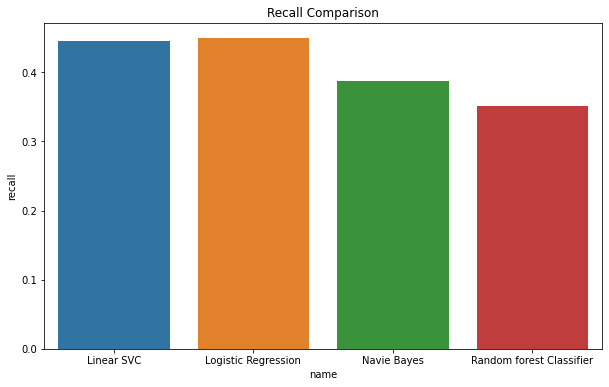

In [ ]:
plt.figure(figsize=(10, 6))

sns.barplot(
    x='name',
    y='recall',
    data=comparing_df,
    #order=comparing_df.sort_values('recall').name
).set_title('Recall Comparison')
plt.show()

[]

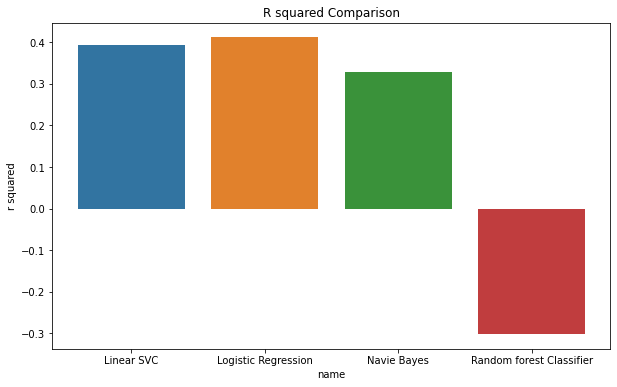

In [ ]:
plt.figure(figsize=(10, 6))

sns.barplot(
    x='name',
    y='r squared',
    data=comparing_df,
    #order=comparing_df.sort_values('accuracy').name
).set_title('R squared Comparison')
plt.plot()

#**Text preprocessing for dataset (without lematiztion)**

In [34]:
dataset_ratings2['cleaned-reviews'] = dataset_ratings2['text'].apply(lambda x: re.sub(r'http\S+', '', x)) 

In [35]:
dataset_ratings2['cleaned-reviews'] = dataset_ratings2['cleaned-reviews'].str.lower()

In [36]:
dataset_ratings2['cleaned-reviews'] = dataset_ratings2['cleaned-reviews'].apply(lambda x: re.sub(r'\d+', '', x))

In [37]:
dataset_ratings2['cleaned-reviews'] = dataset_ratings2['cleaned-reviews'].apply(lambda x:' '.join(x.split()))

In [41]:
punctuation = '"#$%&()*+-/:;<=>@[\\]^_`{|}~\''

dataset_ratings2['cleaned-reviews'] = dataset_ratings2['cleaned-reviews'].apply(lambda x: ''.join(ch for ch in x if ch not in set(punctuation)))

In [42]:
dataset_ratings2.head()

,rating-other-user-rating,text,cleaned-reviews
0,8.0,"The first 80-90% of ""Interstellar"" I absolutel...",the first of interstellar i absolutely loved ...
1,6.0,"As someone who likes the cast, loved the conce...","as someone who likes the cast, loved the conce..."
2,4.0,"Another outer space film from Hollywood, this ...","another outer space film from hollywood, this ..."
3,7.0,"In the near future, Earth is devastated by bli...","in the near future, earth is devastated by bli..."
4,7.0,I'm treading on some little used ground. From ...,im treading on some little used ground. from r...


#**Model comparison for non-lematized text**

In [ ]:
tfidf2 = TfidfVectorizer(ngram_range = (1,4), analyzer = 'word', stop_words='english', max_features = 6000000)

In [ ]:
x2 = tfidf.fit_transform(dataset_ratings2['cleaned-reviews'])
y2 = dataset_ratings2['rating-other-user-rating']

x2.shape, y2.shape

((25267, 4784171), (25267,))

In [ ]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2,y2, test_size = 0.2, random_state = 0)

In [ ]:
clf_1 = LinearSVC(C = 10, class_weight= 'balanced', dual=True, verbose = 2)
clf_1.fit(x_train2, y_train2)

[LibLinear]

LinearSVC(C=10, class_weight='balanced', verbose=2)

In [ ]:
y_pred2_1 = clf_1.predict(x_test2)
print(classification_report(y_test2, y_pred2_1))

              precision    recall  f1-score   support

         1.0       0.53      0.92      0.68       859
         2.0       0.74      0.11      0.19       226
         3.0       0.70      0.10      0.18       227
         4.0       0.64      0.13      0.22       230
         5.0       0.43      0.16      0.23       327
         6.0       0.33      0.26      0.29       360
         7.0       0.34      0.33      0.34       587
         8.0       0.37      0.32      0.34       713
         9.0       0.39      0.24      0.30       627
        10.0       0.45      0.76      0.57       898

    accuracy                           0.45      5054
   macro avg       0.49      0.33      0.33      5054
weighted avg       0.46      0.45      0.40      5054



In [ ]:
clf_2 = LogisticRegression(solver = 'saga', C = 20, class_weight= 'balanced', max_iter= 2000)
clf_2.fit(x_train2, y_train2)

LogisticRegression(C=20, class_weight='balanced', max_iter=2000, solver='saga')

In [ ]:
y_pred2_2 = clf_2.predict(x_test2)
print(classification_report(y_test2, y_pred2_2))

              precision    recall  f1-score   support

         1.0       0.56      0.91      0.69       859
         2.0       0.92      0.10      0.18       226
         3.0       0.74      0.11      0.19       227
         4.0       0.76      0.13      0.23       230
         5.0       0.39      0.16      0.23       327
         6.0       0.30      0.29      0.29       360
         7.0       0.33      0.34      0.34       587
         8.0       0.36      0.34      0.35       713
         9.0       0.41      0.26      0.32       627
        10.0       0.46      0.73      0.57       898

    accuracy                           0.45      5054
   macro avg       0.52      0.34      0.34      5054
weighted avg       0.47      0.45      0.41      5054



In [ ]:
clf_3 = MultinomialNB(alpha = 0)
clf_3.fit(x_train2, y_train2)

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN


MultinomialNB(alpha=0)

In [ ]:
y_pred2_3 = clf_3.predict(x_test2)
print(classification_report(y_test2, y_pred2_3))

              precision    recall  f1-score   support

         1.0       0.77      0.52      0.62       859
         2.0       0.15      0.24      0.18       226
         3.0       0.15      0.28      0.20       227
         4.0       0.14      0.29      0.19       230
         5.0       0.19      0.22      0.20       327
         6.0       0.20      0.25      0.22       360
         7.0       0.30      0.26      0.28       587
         8.0       0.33      0.26      0.29       713
         9.0       0.35      0.34      0.35       627
        10.0       0.51      0.40      0.45       898

    accuracy                           0.34      5054
   macro avg       0.31      0.31      0.30      5054
weighted avg       0.39      0.34      0.35      5054



In [ ]:
clf_4 = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
clf_4.fit(x_train2, y_train2)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

In [ ]:
y_pred2_4 = clf_4.predict(x_test2)
print(classification_report(y_test2, y_pred2_4))

              precision    recall  f1-score   support

         1.0       0.40      0.81      0.53       859
         2.0       0.44      0.09      0.15       226
         3.0       0.53      0.11      0.18       227
         4.0       0.51      0.13      0.21       230
         5.0       0.38      0.13      0.19       327
         6.0       0.32      0.14      0.20       360
         7.0       0.31      0.21      0.25       587
         8.0       0.32      0.23      0.27       713
         9.0       0.35      0.25      0.29       627
        10.0       0.33      0.55      0.41       898

    accuracy                           0.36      5054
   macro avg       0.39      0.27      0.27      5054
weighted avg       0.36      0.36      0.32      5054



In [ ]:
accuracies2 = []
f1_scores2 = []
recalls2 = []
precisions2 = []
r2_scores2 = []


model_names = ['Linear SVC', 'Logistic Regression' , 'Navie Bayes', 'Random forest Classifier']
y_preds2 = [y_pred2_1, y_pred2_2, y_pred2_3, y_pred2_4 ]

for idx, (names, pred) in enumerate(zip(model_names, y_preds2)):
  accuracies2.append(accuracy_score(y_test2, pred))
  f1_scores2.append(f1_score(y_test2, pred, average='weighted'))
  recalls2.append(recall_score(y_test2, pred, average='weighted'))
  precisions2.append(precision_score(y_test2, pred, average='weighted'))
  r2_scores2.append(r2_score(y_test2, pred))

In [ ]:
comparing_df2 = pd.DataFrame.from_dict({
    'name': model_names,
    'accuracy': accuracies2,
    'f1 score': f1_scores2,
    'recall': recalls2,
    'precision': precisions2,
    'r squared': r2_scores2
})

comparing_df2

,name,accuracy,f1 score,recall,precision,r squared
0,Linear SVC,0.447962,0.402245,0.447962,0.456757,0.392282
1,Logistic Regression,0.450139,0.408757,0.450139,0.473176,0.422843
2,Navie Bayes,0.335576,0.354477,0.335576,0.391471,0.347367
3,Random forest Classifier,0.357539,0.318044,0.357539,0.363977,-0.299637


#**Model camparison for without stop words removed (with lematization)**

In [14]:
tfidf3 = TfidfVectorizer(ngram_range = (1,4), analyzer = 'word', stop_words=None, max_features = 6000000)

In [15]:
x3 = tfidf3.fit_transform(dataset_ratings3['cleaned-reviews'])
y3 = dataset_ratings3['rating-other-user-rating']

x3.shape, y3.shape

((25267, 6000000), (25267,))

In [16]:
x_train3, x_test3, y_train3, y_test3 = train_test_split(x3,y3, test_size = 0.2, random_state = 0)

In [ ]:
#clf3_1 = LinearSVC(C = 10, class_weight= 'balanced', dual=True, verbose = 2)
#clf3_1.fit(x_train3, y_train3)

[LibLinear]

LinearSVC(C=10, class_weight='balanced', verbose=2)

In [ ]:
#joblib.dump(clf3_1, 'linearsvcmodel3.h5')

['linearsvcmodel3.h5']

In [17]:
clf3_1 = joblib.load('linearsvcmodel3.h5')

In [18]:
y_pred3_1 = clf3_1.predict(x_test3)
print(classification_report(y_test3, y_pred3_1))

              precision    recall  f1-score   support

         1.0       0.56      0.92      0.70       859
         2.0       0.62      0.12      0.21       226
         3.0       0.61      0.11      0.19       227
         4.0       0.59      0.14      0.23       230
         5.0       0.43      0.19      0.26       327
         6.0       0.30      0.29      0.29       360
         7.0       0.36      0.35      0.36       587
         8.0       0.39      0.34      0.37       713
         9.0       0.37      0.23      0.29       627
        10.0       0.47      0.75      0.58       898

    accuracy                           0.46      5054
   macro avg       0.47      0.35      0.35      5054
weighted avg       0.45      0.46      0.42      5054



In [19]:
#clf3_2 = LogisticRegression(solver = 'saga', C = 20, class_weight= 'balanced', max_iter= 2000)
#clf3_2.fit(x_train3, y_train3)

LogisticRegression(C=20, class_weight='balanced', max_iter=2000, solver='saga')

In [20]:
#joblib.dump(clf3_2, 'logisticregression3.h5')

['logisticregression3.h5']

In [22]:
clf3_2 = joblib.load('logisticregression3.h5')

In [23]:
y_pred3_2 = clf3_2.predict(x_test3)
print(classification_report(y_test3, y_pred3_2))

              precision    recall  f1-score   support

         1.0       0.57      0.91      0.70       859
         2.0       0.89      0.11      0.19       226
         3.0       0.55      0.11      0.18       227
         4.0       0.55      0.14      0.22       230
         5.0       0.40      0.20      0.27       327
         6.0       0.27      0.30      0.28       360
         7.0       0.36      0.37      0.37       587
         8.0       0.37      0.35      0.36       713
         9.0       0.39      0.25      0.30       627
        10.0       0.49      0.73      0.59       898

    accuracy                           0.46      5054
   macro avg       0.49      0.35      0.35      5054
weighted avg       0.46      0.46      0.42      5054



In [24]:
clf3_3 = MultinomialNB(alpha = 0)
clf3_3.fit(x_train3, y_train3)

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN


MultinomialNB(alpha=0)

In [25]:
y_pred3_3 = clf3_3.predict(x_test3)
print(classification_report(y_test3, y_pred3_3))

              precision    recall  f1-score   support

         1.0       0.77      0.67      0.71       859
         2.0       0.44      0.14      0.21       226
         3.0       0.43      0.15      0.23       227
         4.0       0.46      0.16      0.24       230
         5.0       0.31      0.15      0.20       327
         6.0       0.24      0.25      0.25       360
         7.0       0.28      0.35      0.31       587
         8.0       0.27      0.40      0.32       713
         9.0       0.28      0.31      0.30       627
        10.0       0.44      0.51      0.47       898

    accuracy                           0.39      5054
   macro avg       0.39      0.31      0.32      5054
weighted avg       0.41      0.39      0.38      5054



In [26]:
clf3_4 = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
clf3_4.fit(x_train3, y_train3)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

In [27]:
joblib.dump(clf3_4, 'randomforest3.h5')

['randomforest3.h5']

In [28]:
clf3_4 = joblib.load('randomforest3.h5')

In [30]:
y_pred3_4 = clf3_4.predict(x_test3)
print(classification_report(y_test3, y_pred3_4))

              precision    recall  f1-score   support

         1.0       0.40      0.79      0.53       859
         2.0       0.49      0.11      0.17       226
         3.0       0.38      0.10      0.15       227
         4.0       0.41      0.13      0.19       230
         5.0       0.35      0.15      0.21       327
         6.0       0.26      0.15      0.19       360
         7.0       0.30      0.24      0.27       587
         8.0       0.33      0.28      0.30       713
         9.0       0.30      0.22      0.25       627
        10.0       0.35      0.52      0.42       898

    accuracy                           0.35      5054
   macro avg       0.36      0.27      0.27      5054
weighted avg       0.35      0.35      0.32      5054



In [32]:
accuracies3 = []
f1_scores3 = []
recalls3 = []
precisions3 = []
r2_scores3 = []


model_names = ['Linear SVC', 'Logistic Regression' , 'Navie Bayes', 'Random forest Classifier']
y_preds3 = [y_pred3_1, y_pred3_2, y_pred3_3, y_pred3_4 ]

for idx, (names, pred) in enumerate(zip(model_names, y_preds3)):
  accuracies3.append(accuracy_score(y_test3, pred))
  f1_scores3.append(f1_score(y_test3, pred, average='weighted'))
  recalls3.append(recall_score(y_test3, pred, average='weighted'))
  precisions3.append(precision_score(y_test3, pred, average='weighted'))
  r2_scores3.append(r2_score(y_test3, pred))

In [33]:
comparing_df3 = pd.DataFrame.from_dict({
    'name': model_names,
    'accuracy': accuracies3,
    'f1 score': f1_scores3,
    'recall': recalls3,
    'precision': precisions3,
    'r squared': r2_scores3
})

comparing_df3

,name,accuracy,f1 score,recall,precision,r squared
0,Linear SVC,0.457657,0.416303,0.457657,0.453606,0.482226
1,Logistic Regression,0.458251,0.419864,0.458251,0.463040,0.481182
2,Navie Bayes,0.388405,0.384641,0.388405,0.410391,0.374138
3,Random forest Classifier,0.354966,0.320256,0.354966,0.348980,-0.317355


#**Model camparison for without stop words removed (without lematization)**

In [40]:
dataset_ratings2.head()

,rating-other-user-rating,text,cleaned-reviews
0,8.0,"The first 80-90% of ""Interstellar"" I absolutel...",the first of interstellar i absolutely loved ...
1,6.0,"As someone who likes the cast, loved the conce...","as someone who likes the cast, loved the conce..."
2,4.0,"Another outer space film from Hollywood, this ...","another outer space film from hollywood, this ..."
3,7.0,"In the near future, Earth is devastated by bli...","in the near future, earth is devastated by bli..."
4,7.0,I'm treading on some little used ground. From ...,i'm treading on some little used ground. from ...


In [43]:
tfidf4 = TfidfVectorizer(ngram_range = (1,4), analyzer = 'word', stop_words=None, max_features = 6000000)

In [44]:
x4 = tfidf4.fit_transform(dataset_ratings2['cleaned-reviews'])
y4 = dataset_ratings2['rating-other-user-rating']

x4.shape, y4.shape

((25267, 6000000), (25267,))

In [45]:
x_train4, x_test4, y_train4, y_test4 = train_test_split(x4,y4, test_size = 0.2, random_state = 0)

In [46]:
#clf4_1 = LinearSVC(C = 10, class_weight= 'balanced', dual=True, verbose = 2)
#clf4_1.fit(x_train4, y_train4)

[LibLinear]

LinearSVC(C=10, class_weight='balanced', verbose=2)

In [48]:
#joblib.dump(clf4_1, 'linearsvc4.h5')

['linearsvc4.h5']

In [49]:
clf4_1 = joblib.load('linearsvc4.h5')

In [51]:
y_pred4_1 = clf4_1.predict(x_test4)
print(classification_report(y_test4, y_pred4_1))

              precision    recall  f1-score   support

         1.0       0.56      0.93      0.70       859
         2.0       0.71      0.13      0.22       226
         3.0       0.57      0.11      0.18       227
         4.0       0.62      0.14      0.23       230
         5.0       0.42      0.19      0.26       327
         6.0       0.31      0.29      0.30       360
         7.0       0.37      0.37      0.37       587
         8.0       0.39      0.33      0.36       713
         9.0       0.38      0.25      0.30       627
        10.0       0.48      0.75      0.58       898

    accuracy                           0.46      5054
   macro avg       0.48      0.35      0.35      5054
weighted avg       0.46      0.46      0.42      5054



In [52]:
clf4_2 = LogisticRegression(solver = 'saga', C = 20, class_weight= 'balanced', max_iter= 2000)
clf4_2.fit(x_train4, y_train4)

LogisticRegression(C=20, class_weight='balanced', max_iter=2000, solver='saga')

In [53]:
joblib.dump(clf4_2, 'linearsvc4.h5')

['linearsvc4.h5']

In [54]:
clf4_2 = joblib.load('linearsvc4.h5')

In [56]:
y_pred4_2 = clf4_2.predict(x_test4)
print(classification_report(y_test4, y_pred4_2))

              precision    recall  f1-score   support

         1.0       0.58      0.92      0.71       859
         2.0       0.76      0.11      0.19       226
         3.0       0.52      0.11      0.18       227
         4.0       0.60      0.14      0.23       230
         5.0       0.37      0.18      0.25       327
         6.0       0.29      0.31      0.30       360
         7.0       0.36      0.37      0.36       587
         8.0       0.39      0.36      0.38       713
         9.0       0.39      0.27      0.32       627
        10.0       0.50      0.73      0.59       898

    accuracy                           0.46      5054
   macro avg       0.48      0.35      0.35      5054
weighted avg       0.46      0.46      0.42      5054



In [57]:
clf4_3 = MultinomialNB(alpha = 0)
clf4_3.fit(x_train4, y_train4)

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN


MultinomialNB(alpha=0)

In [58]:
y_pred4_3 = clf4_3.predict(x_test4)
print(classification_report(y_test4, y_pred4_3))

              precision    recall  f1-score   support

         1.0       0.75      0.66      0.70       859
         2.0       0.42      0.13      0.20       226
         3.0       0.37      0.12      0.19       227
         4.0       0.44      0.16      0.24       230
         5.0       0.31      0.16      0.21       327
         6.0       0.23      0.28      0.25       360
         7.0       0.27      0.34      0.30       587
         8.0       0.28      0.38      0.33       713
         9.0       0.30      0.33      0.31       627
        10.0       0.44      0.54      0.49       898

    accuracy                           0.39      5054
   macro avg       0.38      0.31      0.32      5054
weighted avg       0.41      0.39      0.39      5054



In [59]:
clf4_4 = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
clf4_4.fit(x_train4, y_train4)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

In [60]:
joblib.dump(clf4_4, 'randomforest4.h5')

['randomforest4.h5']

In [61]:
joblib.load('randomforest4.h5')

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

In [62]:
y_pred4_4 = clf4_4.predict(x_test4)
print(classification_report(y_test4, y_pred4_4))

              precision    recall  f1-score   support

         1.0       0.37      0.80      0.51       859
         2.0       0.40      0.12      0.18       226
         3.0       0.46      0.10      0.16       227
         4.0       0.46      0.13      0.20       230
         5.0       0.30      0.12      0.17       327
         6.0       0.27      0.16      0.20       360
         7.0       0.36      0.23      0.28       587
         8.0       0.28      0.25      0.27       713
         9.0       0.28      0.22      0.25       627
        10.0       0.34      0.44      0.38       898

    accuracy                           0.34      5054
   macro avg       0.35      0.26      0.26      5054
weighted avg       0.34      0.34      0.30      5054



In [63]:
accuracies4 = []
f1_scores4 = []
recalls4 = []
precisions4 = []
r2_scores4 = []


model_names = ['Linear SVC', 'Logistic Regression' , 'Navie Bayes', 'Random forest Classifier']
y_preds4 = [y_pred4_1, y_pred4_2, y_pred4_3, y_pred4_4 ]

for idx, (names, pred) in enumerate(zip(model_names, y_preds3)):
  accuracies4.append(accuracy_score(y_test4, pred))
  f1_scores4.append(f1_score(y_test4, pred, average='weighted'))
  recalls4.append(recall_score(y_test4, pred, average='weighted'))
  precisions4.append(precision_score(y_test4, pred, average='weighted'))
  r2_scores4.append(r2_score(y_test4, pred))

In [64]:
comparing_df4 = pd.DataFrame.from_dict({
    'name': model_names,
    'accuracy': accuracies4,
    'f1 score': f1_scores4,
    'recall': recalls4,
    'precision': precisions4,
    'r squared': r2_scores4
})

comparing_df4

,name,accuracy,f1 score,recall,precision,r squared
0,Linear SVC,0.457657,0.416303,0.457657,0.453606,0.482226
1,Logistic Regression,0.458251,0.419864,0.458251,0.463040,0.481182
2,Navie Bayes,0.388405,0.384641,0.388405,0.410391,0.374138
3,Random forest Classifier,0.354966,0.320256,0.354966,0.348980,-0.317355
